In [112]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger,TensorBoard,EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mplimg

In [25]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), padding = 'same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D((2,2))(x)
    return x, p

def decoder_block(inputs, skip_connection, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), padding = 'same', strides = 2)(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_connection])
    x = conv_block(x, num_filters)
    return x

def unet(input_shape):
    """Encoder"""
    Input = tf.keras.layers.Input(shape = input_shape)
    s1, p1 = encoder_block(Input, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    "BottleNeck"
    b = conv_block(p4, 1024)
    
    """Decoder"""
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    Output = tf.keras.layers.Conv2D(1, 1, padding = 'same', activation = 'sigmoid')(d4)
    
    model = tf.keras.models.Model(inputs = Input, outputs = Output, name = "UNET")
    return model

In [27]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [28]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true*y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [29]:
H = 512
W = 512

In [30]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
def load_data(path):
    x = sorted(glob(os.path.join(train_path, "images", "*.jpg")))
    y = sorted(glob(os.path.join(train_path, "mask", "*.jpg")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state = 42)
    return x, y

def read_image(path):
    path = path.decode() #decode isliye use kra h kyunki yeh tensorflow ke sath use hoga.
    x = cv2.imread(path, cv2.IMREAD_COLOR)
#     x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis = -1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H,W,3])
    y.set_shape([H,W,1])
    return x, y

def tf_dataset(X, Y, batch_size = 2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(2)
    return dataset

In [31]:
"""Directory to save files"""
create_dir("files")

"""Hyper Parameters"""
batch_size = 2
lr = 1e-4
EPOCHS = 100
model_path = os.path.join("gdrive/MyDrive/Retina Blood Vessel Segmentation using UNET/files", "model.h5")
csv_path = os.path.join("gdrive/MyDrive/Retina Blood Vessel Segmentation using UNET/files", "data.csv")

"""Dataset Path"""
dataset_path = "gdrive/MyDrive/Retina Blood Vessel Segmentation using UNET/new_data"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
test_x = sorted(glob(os.path.join(test_path, "images", "*.jpg")))

train_x, train_y = shuffling(train_x, train_y)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)}")

Train: 120 - 120
Test: 20


In [32]:
"""Dataset"""
train_dataset = tf_dataset(train_x[:100], train_y[:100], batch_size = batch_size)
valid_dataset = tf_dataset(train_x[100:], train_y[100:], batch_size = batch_size)

train_steps = 100//batch_size
valid_steps = 20//batch_size

In [33]:
"""Model"""
model = unet((H, W, 3))

In [34]:
lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = lr,
                                                             decay_steps = 1000, decay_rate = 0.96,
                                                            staircase = True)
callbacks = [
             ModelCheckpoint(model_path, verbose = 1, save_best_only = True),
             CSVLogger(csv_path),
             TensorBoard(log_dir = "./logs"),
             EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
            ]

model.compile(loss = dice_loss, optimizer = tf.keras.optimizers.Adam(lr_schedule), metrics = [dice_coef, iou, Recall(), Precision()])

In [35]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 512, 512, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 512, 512, 64) 256         conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_54 (Activation)      (None, 512, 512, 64) 0           batch_normalization_54[0][0]     
_______________________________________________________________________________________________

In [36]:
r = model.fit(
            train_dataset,
            epochs = 50,
            validation_data = valid_dataset,
            steps_per_epoch = train_steps,
            validation_steps = valid_steps,
            callbacks = callbacks
            )

Epoch 1/50
50/50 [==============================] - 93s 2s/step - loss: 0.7666 - dice_coef: 0.2334 - iou: 0.1324 - recall_3: 0.7902 - precision_3: 0.3110 - val_loss: 0.8336 - val_dice_coef: 0.1664 - val_iou: 0.0908 - val_recall_3: 1.0000 - val_precision_3: 0.2171

Epoch 00001: val_loss improved from inf to 0.83357, saving model to gdrive/MyDrive/Retina Blood Vessel Segmentation using UNET/files/model.h5
Epoch 2/50
50/50 [==============================] - 91s 2s/step - loss: 0.6858 - dice_coef: 0.3142 - iou: 0.1879 - recall_3: 0.4124 - precision_3: 0.4017 - val_loss: 0.8336 - val_dice_coef: 0.1664 - val_iou: 0.0908 - val_recall_3: 1.0000 - val_precision_3: 0.2171

Epoch 00002: val_loss did not improve from 0.83357
Epoch 3/50
50/50 [==============================] - 92s 2s/step - loss: 0.6382 - dice_coef: 0.3618 - iou: 0.2235 - recall_3: 0.2775 - precision_3: 0.4836 - val_loss: 1.0000 - val_dice_coef: 4.4659e-05 - val_iou: 2.2335e-05 - val_recall_3: 9.6663e-06 - val_precision_3: 1.0000



In [40]:
# !zip -r 'files.zip' 'gdrive/MyDrive/Retina Blood Vessel Segmentation using UNET/files'

In [39]:
# !zip -r 'logs.zip' 'logs'

  adding: logs/ (stored 0%)
  adding: logs/validation/ (stored 0%)
  adding: logs/validation/events.out.tfevents.1631182510.1a72ede7e9dd.76.3.v2 (deflated 79%)
  adding: logs/train/ (stored 0%)
  adding: logs/train/plugins/ (stored 0%)
  adding: logs/train/plugins/profile/ (stored 0%)
  adding: logs/train/plugins/profile/2021_09_09_10_13_51/ (stored 0%)
  adding: logs/train/plugins/profile/2021_09_09_10_13_51/1a72ede7e9dd.input_pipeline.pb (deflated 58%)
  adding: logs/train/plugins/profile/2021_09_09_10_13_51/1a72ede7e9dd.xplane.pb (deflated 78%)
  adding: logs/train/plugins/profile/2021_09_09_10_13_51/1a72ede7e9dd.memory_profile.json.gz (stored 0%)
  adding: logs/train/plugins/profile/2021_09_09_10_13_51/1a72ede7e9dd.overview_page.pb (deflated 59%)
  adding: logs/train/plugins/profile/2021_09_09_10_13_51/1a72ede7e9dd.tensorflow_stats.pb (deflated 70%)
  adding: logs/train/plugins/profile/2021_09_09_10_13_51/1a72ede7e9dd.trace.json.gz (deflated 3%)
  adding: logs/train/plugins/profile

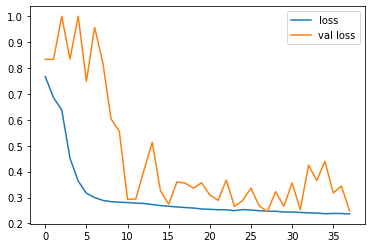

In [42]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

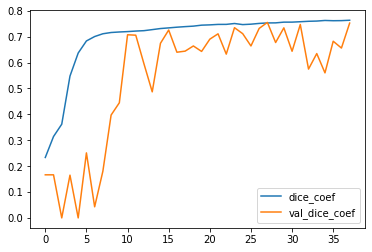

In [43]:
plt.plot(r.history['dice_coef'], label = 'dice_coef')
plt.plot(r.history['val_dice_coef'], label = 'val_dice_coef')
plt.legend()
plt.show()

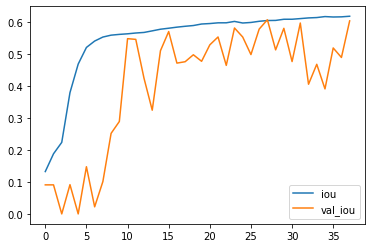

In [44]:
plt.plot(r.history['iou'], label = 'iou')
plt.plot(r.history['val_iou'], label = 'val_iou')
plt.legend()
plt.show()

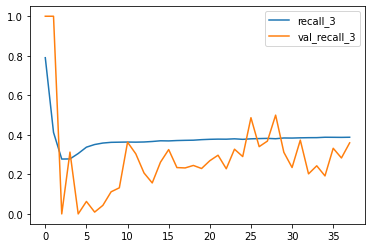

In [45]:
plt.plot(r.history['recall_3'], label = 'recall_3')
plt.plot(r.history['val_recall_3'], label = 'val_recall_3')
plt.legend()
plt.show()

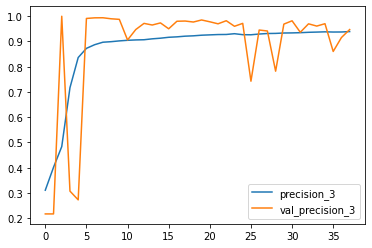

In [46]:
plt.plot(r.history['precision_3'], label = 'precision_3')
plt.plot(r.history['val_precision_3'], label = 'val_precision_3')
plt.legend()
plt.show()

In [52]:
with tf.keras.utils.CustomObjectScope({'iou': iou, 'dice_coef':dice_coef, 'dice_loss': dice_loss}):
    mdl = tf.keras.models.load_model('gdrive/MyDrive/Retina Blood Vessel Segmentation using UNET/files/model.h5')

In [91]:
"""Saving the images"""
create_dir("results")

def save_results(y_pred, save_image_path):
    y_pred = np.expand_dims(y_pred, axis=-1)
    cv2.imwrite(save_image_path, y_pred)

In [117]:
pred_mask = []
test_images = []
for test_img in test_x:
    name = test_img.split("/")[-1].split(".")[0]
    test_img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    test_img = test_img / 255.0
    test_images.append(test_img)
    test_img = np.expand_dims(test_img, axis = -1).reshape(1, 512, 512,3)
    # test_img = test_img > 0.5
    predicted = mdl.predict(test_img)
    save_image_path = f"results/{name}.png"
    # plt.imsave(save_image_path, predicted.reshape(512, 512))
    # cv2.imwrite(save_image_path,predicted.reshape(512,512,3) )
    mplimg.imsave(save_image_path, predicted.reshape(512, 512), cmap = plt.cm.gray)
    pred_mask.append(predicted)

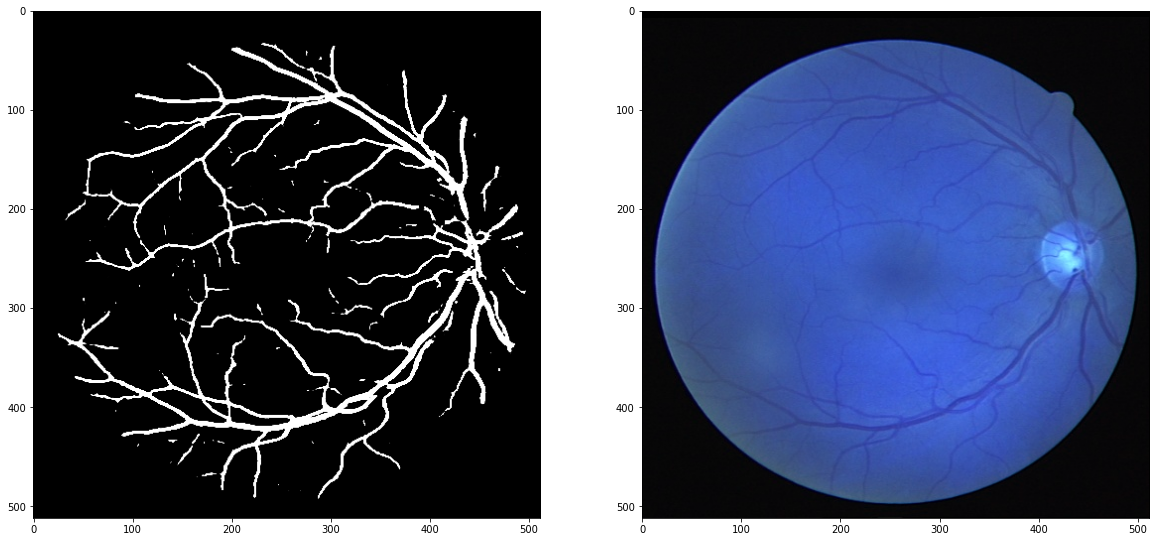

In [118]:
f, ax = plt.subplots(1,2 ,figsize = (20,20))

ax[0].imshow(pred_mask[-1].reshape(512, 512), cmap = 'gray')
ax[1].imshow(test_images[-1].reshape(512,512,3))

In [119]:
 !zip -r 'results.zip' 'results'
# !rm -rf 'results'

  adding: results/ (stored 0%)
  adding: results/05_test.png (deflated 3%)
  adding: results/09_test.png (deflated 3%)
  adding: results/18_test.png (deflated 3%)
  adding: results/10_test.png (deflated 3%)
  adding: results/06_test.png (deflated 3%)
  adding: results/13_test.png (deflated 2%)
  adding: results/02_test.png (deflated 3%)
  adding: results/11_test.png (deflated 3%)
  adding: results/01_test.png (deflated 2%)
  adding: results/19_test.png (deflated 2%)
  adding: results/12_test.png (deflated 3%)
  adding: results/08_test.png (deflated 3%)
  adding: results/17_test.png (deflated 3%)
  adding: results/.ipynb_checkpoints/ (stored 0%)
  adding: results/16_test.png (deflated 2%)
  adding: results/20_test.png (deflated 3%)
  adding: results/07_test.png (deflated 3%)
  adding: results/14_test.png (deflated 3%)
  adding: results/15_test.png (deflated 3%)
  adding: results/03_test.png (deflated 3%)
  adding: results/04_test.png (deflated 3%)


In [90]:
# !rm -rf 'results.zip'